# 환경설정

In [1]:
# 환경설정 로드
from dotenv import load_dotenv
load_dotenv()

# 랭스미스 로깅 활성화
from langchain_teddynote import logging
logging.langsmith("PDF_WITH_SEARCH_AI")

LangSmith 추적을 시작합니다.
[프로젝트명]
PDF_WITH_SEARCH_AI


### 폴더 내 파일들 리스트로 변환

In [2]:
import os
def list_files_with_paths(directory):
    """
    :param directory: 디렉토리 경로
    경로의 하위폴더의 파일까지 모두 가져와 경로가 붙은 파일명 리스트 리턴
    """
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

source_list = list_files_with_paths("./pdf/")
source_list

['./pdf/근로기준법.pdf', './pdf/근로기준법_시행규칙.pdf', './pdf/근로기준법_시행령.pdf']

### PDF로딩 후 DB에 임베딩

In [4]:
# PDF 로딩
# OPENAI_API_KEY, UPSTAGE_API_KEY 필요
from rag.pdf import PDFRetrievalChain
pdf = PDFRetrievalChain(source_list).create_chain(True)
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

  0%|          | 0/260 [00:00<?, ?it/s]

  0%|          | 0/260 [00:00<?, ?it/s]

[fit_sparse_encoder]
Saved Sparse Encoder to: ../sparse_encoder.pkl


문서 Upsert 중:   0%|          | 0/9 [00:00<?, ?it/s]

총 260개의 Vector 가 Upsert 되었습니다.
{'dimension': 4096,
 'index_fullness': 0.0,
 'namespaces': {'ns1': {'vector_count': 164},
                'sashin1': {'vector_count': 182},
                'sashin2': {'vector_count': 182}},
 'total_vector_count': 528}
[init_pinecone_index]
{'dimension': 4096,
 'index_fullness': 0.0,
 'namespaces': {'ns1': {'vector_count': 260},
                'sashin1': {'vector_count': 182},
                'sashin2': {'vector_count': 182}},
 'total_vector_count': 624}


## GraphState 클래스 생성
질문, 컨텍스트, 대답, 관련성 정보를 계속 가지고 다닐 필요가 있음

In [5]:
from typing import TypedDict
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # 답변
    relevance: str  # 답변의 문서에 대한 관련성

### 각 노드로 사용할 메소드들 작성

In [6]:
from langchain_upstage import UpstageGroundednessCheck
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults
from rag.utils import format_docs, format_searched_docs

# 업스테이지 문서 관련성 체크 기능을 설정합니다. https://upstage.ai
upstage_ground_checker = UpstageGroundednessCheck()


# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
def retrieve_document(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(state["question"])

    # 검색된 문서를 형식화합니다.
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# LLM을 사용하여 답변을 생성합니다.
def llm_answer(state: GraphState) -> GraphState:
    question = state["question"]
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke({"question": question, "context": context})

    return GraphState(answer=response)


def rewrite(state):
    question = state["question"]
    answer = state["answer"]
    context = state["context"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini")

    chain = prompt | model | StrOutputParser()
    response = chain.invoke(
        {"question": question, "answer": answer, "context": context}
    )
    return GraphState(question=response)


def search_on_web(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": state["question"]})

    # 검색된 문서를 형식화합니다.
    search_result = format_searched_docs(search_result)
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(
        context=search_result,
    )


def relevance_check(state: GraphState) -> GraphState:
    print("relevance_check", state)
    # 관련성 체크를 실행합니다. 결과: grounded, notGrounded, notSure
    response = upstage_ground_checker.run(
        {"context": state["context"], "answer": state["answer"]}
    )
    return GraphState(
        relevance=response, question=state["question"], answer=state["answer"]
    )


def is_relevant(state: GraphState) -> GraphState:
    return state["relevance"]

## 랭그래프 로직 작성

In [7]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 에이전트 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 정보 검색 노드를 추가합니다.
workflow.add_node(
    "relevance_check", relevance_check
)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.
# workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", "relevance_check")  # 답변 -> 관련성 체크


# workflow.add_edge("rewrite", "search_on_web")  # 1. 재작성 -> 웹 검색
# workflow.add_edge("search_on_web", "llm_answer")  # 웹 검색 -> 답변


workflow.add_edge("rewrite", "retrieve")  # 2. 재작성 -> 리트리브




# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": END,  # 관련성이 있으면 종료합니다.
        "notGrounded": "rewrite",  # 관련성이 없으면 다시 답변을 생성합니다.
        "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)


workflow.set_entry_point("retrieve")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

### 랭그래프 로직 머메이드로 그려보기

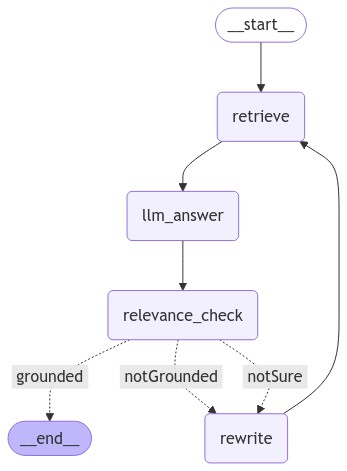

In [8]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

# 랭그래프 동작시켜보기

In [9]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    question="나 어제 늦잠자서 회사에 30분 늦었는데, 해고하겠데 ㅠㅠ"
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

"Output from node 'retrieve':"
'---'
{ 'context': '<document><content>근로기준법\n'
             '제25조(우선 재고용 등) ① 제24조에 따라 근로자를 해고한 사용자는 근로자를 해고한 날부터 3년 이내에 해고된 '
             '근로\n'
             '자가 해고 당시 담당하였던 업무와 같은 업무를 할 근로자를 채용하려고 할 경우 제24조에 따라 해고된 근로자가 원\n'
             '하면 그 근로자를 우선적으로 고용하여야 한다.\n'
             '② 정부는 제24조에 따라 해고된 근로자에 대하여 생계안정, 재취업, 직업훈련 등 필요한 조치를 우선적으로 취하여\n'
             '야 한다.\n'
             '제26조(해고의 예고) 사용자는 근로자를 해고(경영상 이유에 의한 해고를 포함한다)하려면 적어도 30일 전에 예고를 '
             '하\n'
             '여야 하고, 30일 전에 예고를 하지 아니하였을 때에는 30일분 이상의 통상임금을 지급하여야 한다. 다만, 다음 각 '
             '호</content><source>근로기준법.pdf</source><page>4</page></document>\n'
             '<document><content>2. 근로자가 저축증서 등 관련 자료의 열람 또는 반환을 요구할 때에는 즉시 이에 '
             '따를 것\n'
             '제23조(해고 등의 제한) ① 사용자는 근로자에게 정당한 이유 없이 해고, 휴직, 정직, 전직, 감봉, 그 밖의 '
             '징벌(懲罰)(이\n'
             '하 “부당해고등”이라 한다)을 하지 못한다.\n'
             '② 사용자는 근로자가 업무상 부상 또는 질병의 요양을 위하여 휴업한 기간과 그 후 30일 동안 또는 '
          